Code adapted from https://github.com/mzydiao/FBGVI/blob/main/FBGVI-Experiments.ipynb.

Mainly just edited it to include the BW-FISTA algorithm.


To Do
1.   Ensure that algorithm is implemented correctly **(Checked)**
2.   **(Important)** Check for numerical stability issues
3.   Check for symmetry issues **(Only small issues from numerical errors that I've finished resolving)**
4.   Check for eigenvalue issues

*   Does the algorithm ever hit the problematic 0 eigenvalues
*   Find out where negative eigenvalues come from **(When $S_k+I$ hits negative, we have issues)**
*   Find out where complex eigenvalues come from **(Resolved from ensuring symmetry)**
5.   Is stepsize an issue **(shrinking stepsize lets algorithm run for longer but not by much more, need more rigorous analysis w/ smoothness)**
6.   Check which line of the algorithm is problematic **(Seems to be $S_k+I$)**
7.   Plot out projected distribution to see visually how convergence behavior
8.   If the issue is in the theory/principle vs implementation, explore ways to clip eigenvalues
9.   Why is distance negative? **(Not an issue, because we take the log of KL divergence and not just KL)**

From GPT:
1.   Check condition number **(Matrix becomes very ill-conditioned as expected; where does ill-conditioning come from: numerical issues, non-PSD, etc.?)**
2.   Add small $\epsilon I$ perturbation for numerical stability **(Implemented, doesn't seem to work?)**




In [1]:
# math
import numpy as np
from numpy.random import multivariate_normal as mvn
from scipy.stats import ortho_group, uniform, bernoulli
from scipy.linalg import sqrtm
from scipy.optimize import minimize

# plotting/visualization
import matplotlib.pyplot as plt
from cycler import cycler
from jax import hessian

# python utils
from functools import partial

In [2]:
def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

In [3]:
def clip_matrix(M: np.array, upper):
    """
    Assuming that M is PSD, return the matrix obtained by clipping the singular values at upper.
    """
    eigs = np.linalg.eig(M)
    return eigs[1] @ np.diag(np.minimum(eigs[0], upper)) @ eigs[1].T

In [4]:
def wasserstein_dist(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the squared W2 distance between N(mu_0, Sigma_0), N(mu_1, Sigma_1).
    """
    half_0 = sqrtm(Sigma_0)
    half_1 = sqrtm(Sigma_1)
    return np.sum((mu_0 - mu_1) ** 2) + np.sum((half_0 - half_1) ** 2)

In [5]:
epsilon = 1e-6
def H(mu, Sigma):
    """
    Return the negentropy of N(mu, Sigma).
    """
    d = len(mu)
    assert d == Sigma.shape[0] and d == Sigma.shape[1]
    return -(
        d/2 * (1 + np.log(2 * np.pi))
        + 1/2 * np.log(np.linalg.det(Sigma))
    )

def kl_divergence(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the KL divergence
    KL( N(mu_0, Sigma_0) || N(mu_1, Sigma_1) ).
    """
    d = mu_0.shape[0]

    det_0 = np.linalg.det(Sigma_0)
    det_1 = np.linalg.det(Sigma_1)
    Sigma_1_inv = np.linalg.inv(Sigma_1)
    div = np.log(det_1) - np.log(det_0)
    div -= d
    div += (Sigma_1_inv * Sigma_0).sum()
    div += (mu_1 - mu_0).T @ Sigma_1_inv @ (mu_1 - mu_0)
    div /= 2
    return div

In [6]:
def softmax(x):
    """
    Univariate softmax function.
    """
    return np.exp(x) / (1 + np.exp(x))

In [30]:
class Experiment():
    """
    Parent class for experiments.
    Implements BWGD and FBGVI and plots results.
    """

    def __init__(
        self,
        log_potential,
        gradient_oracle,
        dist_objective,
        dist_objective_name = r"$\mathcal{F}(p_k)$",
        dim = 5, beta = 1,
        grad_V = None,
        hess_V = None,
    ):
        """
        Initialize parameters of experiment:
        - params: dim, beta
        - log_potential
            * takes in a vector x and produces the unnormalized log potential.
        - dist_objective
            * (mu, Sigma) -> objective function to plot
            * by default, we can make this equal to EE_p V - H(p)
        - gradient_oracle
            * (mu, Sigma) -> estimate for (EE nabla V, EE nabla^2 V)
            * default:
                > draw x ~ N(mu, Sigma)
                > compute v = V(x)
                > v.backward()
                > x.grad
        - initialize Sigma_0 at isotropic Gaussian
        """

        self.log_potential = log_potential
        self.gradient_oracle = gradient_oracle
        self.dist_objective = dist_objective
        self.dist_objective_name = dist_objective_name
        self.dim = dim
        self.grad_V = grad_V
        self.hess_V = hess_V

        # initialize mean with all zeros
        self.init_mu = np.zeros(dim)

        # initialize Sigma at identity
        self.init_Sigma = np.eye(dim) / beta

    def laplace_approx(self):
        """
        Compute Laplace approximation to target distribution.
        """
        if self.hess_V is None:
            raise NotImplementedError

        x0 = np.zeros(self.dim)

        # compute MAP
        result = minimize(
            self.log_potential,
            x0,
            jac = self.grad_V,
            hess = self.hess_V
        )
        mu = result.x

        # compute Hessian at map
        H = self.hess_V(mu)

        # compute inverse of Hessian to obtain Sigma
        Sigma = np.linalg.inv(H + epsilon * np.eye(self.dim))

        return mu, Sigma

    def is_symmetric(self, matrix, iternum, matrix_name):
        if not np.array_equal(matrix, matrix.T):
          print(matrix_name + " " + str(iternum) + " is not symmetric")
          trunc_matrix = np.trunc(matrix * 100) / 100
          print(trunc_matrix)
          print("\n\n")

    def is_psd_short(self, matrix, iternum, matrix_name):
        eigenvalues = np.linalg.eigvals(matrix)
        if not bool(np.all(eigenvalues >= 0)):
            self.is_psd_long(matrix, iternum, matrix_name)

    def is_psd_long(self, matrix, iternum, matrix_name):
        eigenvalues = np.linalg.eigvals(matrix)
        print(matrix_name + " " + str(iternum) +" : " + str(bool(np.all(eigenvalues >= 0))))
        print("Min Eig " + matrix_name + " " + str(iternum) + " " + str(min(eigenvalues)))
        print("\n\n")

    def make_symmetric(self, matrix):
        upper_triangle = np.triu(matrix)
        symmetric_matrix = upper_triangle + upper_triangle.T - np.diag(upper_triangle.diagonal())
        return symmetric_matrix

    def compute_condition_number(self, matrix, matrix_name, iternum):
        try:
            # Ensure matrix is symmetric
            matrix = self.make_symmetric(matrix)

            # Compute eigenvalues
            eigenvalues = np.linalg.eigvals(matrix)
            max_eig = np.max(np.abs(eigenvalues))
            min_eig = np.min(np.abs(eigenvalues))

            # Compute condition number
            condition_number = max_eig / (min_eig + 1e-10)  # Add small constant to avoid division by zero

            print(f"Condition number of {matrix_name} at iteration {iternum}: {condition_number:.2e}")
            print(f"Max eigenvalue: {max_eig:.2e}")
            print(f"Min eigenvalue: {min_eig:.2e}\n")

            return condition_number
        except np.linalg.LinAlgError:
            print(f"Failed to compute condition number for {matrix_name} at iteration {iternum}")
            return float('inf')

    def run_iter(self, alg, eta, mu, Sigma, mean = None, Cov = None, iternum = 1):
        """
        Run an iteration of the specified algorithm to update (mu, Sigma).
        Returns new (mu, Sigma).
        """
        hat_nabla1, hat_nabla2 = self.gradient_oracle(mu, Sigma)
        r = 3
        tau = iternum / (iternum + r)

        # compute gradient in mu
        # (update is the same between BWGD and FBGVI)
        # grad_mu = self.Sigma_true_inv @ (mu - self.mu_true)
        mu = mu - eta * hat_nabla1
        mu_copy = mu.copy()

        if alg == "bwgd":
            # compute gradient in Sigma
            M = np.eye(self.dim) - eta * (hat_nabla2 - np.linalg.inv(Sigma))
            Sigma = M @ Sigma @ M

            mean = mu
            Cov = Sigma

        elif alg == "fbgvi":
            # do forward step for the energy
            M_half = np.eye(self.dim) - eta * hat_nabla2
            Sigma_half = M_half @ Sigma @ M_half

            # do backward step for the entropy

            sqrt_matrix = sqrtm(
                Sigma_half @ (Sigma_half + 4 * eta * np.eye(self.dim))
            )
            sqrt_matrix = np.real(sqrt_matrix)
            Sigma = 0.5 * (Sigma_half + 2 * eta * np.eye(self.dim) + sqrt_matrix)

            mean = mu
            Cov = Sigma

        elif alg == "bwfista":
            iternum += 1 # to match that we start from mu_1

            # do forward step for the energy
            mu = mu + tau * (mu - mean)
            mean = mu_copy

            M_half = np.eye(self.dim) - eta * hat_nabla2
            M_half = self.make_symmetric(M_half)

            Sigma_half = M_half @ Sigma @ M_half
            Sigma_half = self.make_symmetric(Sigma_half)
            self.is_psd_short(Sigma_half, iternum, "Sigma half")
            #self.compute_condition_number(Sigma_half, "Sigma half", iternum)

            sqrt_matrix = sqrtm(
                Sigma_half @ (Sigma_half + 4 * eta * np.eye(self.dim) + epsilon * np.eye(self.dim))
            )
            sqrt_matrix = np.real(sqrt_matrix)
            sqrt_matrix = self.make_symmetric(sqrt_matrix)
            cur_Cov = 0.5 * (Sigma_half + 2 * eta * np.eye(self.dim) + sqrt_matrix) + epsilon * np.eye(self.dim)
            cur_Cov = self.make_symmetric(cur_Cov)

            self.is_psd_short(cur_Cov, iternum, "Cur Cov")
            #self.compute_condition_number(cur_Cov, "Cur Cov", iternum)

            Cov = Cov + epsilon * np.eye(self.dim)
            Cov_sqrt = np.real(sqrtm(Cov))
            Cov_sqrt_inv = np.linalg.inv(Cov_sqrt + epsilon * np.eye(self.dim))
            Cov_sqrt_inv = self.make_symmetric(Cov_sqrt_inv)
            inner_mat = np.real(sqrtm(Cov_sqrt @ cur_Cov @ Cov_sqrt))
            inner_mat = self.make_symmetric(inner_mat)
            S_k = (1 + tau) * (Cov_sqrt_inv @ inner_mat @ Cov_sqrt_inv - np.eye(self.dim))

            S_k = self.make_symmetric(S_k)

            self.is_psd_short(S_k + np.eye(self.dim), iternum, "S_k + I")

            Sigma = (np.eye(self.dim) + S_k) @ Sigma @ (np.eye(self.dim) + S_k)

            Cov = cur_Cov

            eigenvalues_Sigma = np.linalg.eigvals(Sigma)
            print("Sigma " + str(iternum) +" : " + str(bool(np.all(eigenvalues_Sigma >= 0))))
            print("Min Eig Sigma: " + str(min(eigenvalues_Sigma)))
            if not bool(np.all(eigenvalues_Sigma > 0)):
                if np.any(np.abs(eigenvalues_Sigma) < 1e10):
                    print("Sigma " + iternum + " has 0 eigenvalue")
            Sigma = self.make_symmetric(Sigma)
            self.compute_condition_number(Sigma, "Sigma", iternum)
            self.is_symmetric(Cov, iternum, "Cov")

            eigenvalues_Cov = np.linalg.eigvals(Cov)
            print("Cov " + str(iternum) +" : " + str(bool(np.all(eigenvalues_Cov >= 0))))
            print("Min Eig Cov: " + str(min(eigenvalues_Cov)))


        else:
            raise NotImplementedError

         #probably unnecessary

        return mu, Sigma, mean, Cov

    def run_experiment(
        self,
        iters_list = 10000, time = 10000,
        init_mu = None, init_Sigma = None,
        plot_laplace = False
    ):
        """
        Run both BWGD and FBGVI and BWFISTA.
        """
        alg_dists = []
        time_axes = []
        if init_mu is None:
            init_mu = self.init_mu
        if init_Sigma is None:
            init_Sigma = self.init_Sigma

        for iters in iters_list:
            print(iters)
            step_size_multiple = 1
            eta = time / (step_size_multiple * iters)
            gd_mu_k, gd_Sigma_k = init_mu, init_Sigma
            prox_mu_k, prox_Sigma_k = init_mu, init_Sigma
            #fista_mu_k, fista_Sigma_k = init_mu, init_Sigma
            #fista_mean_k, fista_Cov_k = init_mu, init_Sigma

            gd_dists = [self.dist_objective(gd_mu_k, gd_Sigma_k)]
            prox_dists = [self.dist_objective(prox_mu_k, prox_Sigma_k)]
            #fista_dists = [self.dist_objective(fista_mu_k, fista_Sigma_k)]

            for k in range(iters):
                try:
                    new_mu, new_Sigma, *_ = (
                        self.run_iter("bwgd", eta, gd_mu_k, gd_Sigma_k)
                    )
                    gd_mu_k, gd_Sigma_k = new_mu, new_Sigma
                    gd_dists.append(self.dist_objective(gd_mu_k, gd_Sigma_k))
                except np.linalg.LinAlgError:
                    still_psd = False
                    print("np linalg error from trying to sample from MVN!")
                    gd_dists.append(gd_dists[-1])
            for k in range(iters):
                new_mu, new_Sigma, *_ = self.run_iter("fbgvi", eta, prox_mu_k, prox_Sigma_k)
                prox_mu_k, prox_Sigma_k = new_mu, new_Sigma
                prox_dists.append(self.dist_objective(prox_mu_k, prox_Sigma_k))
            print("FBVI Distances: ")
            print(prox_dists)
            #for k in range(iters):
                #new_mu, new_Sigma, new_mean, new_Cov = self.run_iter("bwfista", eta, fista_mu_k, fista_Sigma_k, fista_mean_k, fista_Cov_k, k)
                #fista_mu_k, fista_Sigma_k, fista_mean_k, fista_Cov_k = new_mu, new_Sigma, new_mean, new_Cov
                #fista_dist_k = self.dist_objective(fista_mu_k, fista_Sigma_k)
                #fista_dists.append(fista_dist_k)
                #print("BW-FISTA Distance " + str(k + 1) + " : "+ str(fista_dist_k) )
                #print("\n")

            alg_dists += [
                (fr'BWGD, $\eta = {eta:.3f}$', gd_dists),
                (fr'FBGVI, $\eta = {eta:.3f}$', prox_dists),
                #(fr'BW-FISTA, $\eta = {eta:.3f}$', fista_dists)
            ]
            print(prox_dists)
            #print(fista_dists)
            time_axes += [
                np.linspace(0, time, iters+1),
                np.linspace(0, time, iters+1)#,
                #np.linspace(0, time, iters+1)
            ]
        print("Len Time: ", len(time_axes))
        print("Len Algs: ", len(alg_dists))
        self.plot_results(
            time_axes, alg_dists, plot_laplace = plot_laplace
        )

    def plot_results(
        self, time_axes, alg_dists, ax = None, plot_laplace = False
    ):
        """
        Plot distances and label results for all the algorithms of interest.
        """

        # configure plot

        plt.title(fr"{self.dist_objective_name} over iterations")
        plt.xlabel(r"time elapsed ($\eta \times \# $iters)")
        plt.ylabel(self.dist_objective_name)

        fig = plt.gcf()
        fig.set_size_inches(8, 5)
        fig.set_dpi(160)

        if ax is None:
            ax = plt.gca()
        ax.set_prop_cycle(
            cycler('color', list(plt.rcParams["axes.prop_cycle"].by_key()["color"])) *
            cycler('linestyle', ['-', '--'])
        )

        for time, (alg_name, dists) in zip(time_axes, alg_dists):
            """
            Plot distances and label results for particular algorithm of interest.
            """
            dists = np.array(dists)
            ax.plot(time, dists, label = alg_name, linewidth=0.8)
        if plot_laplace:
            # draw laplace approximation error
            laplace_mu, laplace_Sigma = self.laplace_approx()
            ax.axhline(
                self.dist_objective(laplace_mu, laplace_Sigma),
                label="Laplace approx"
            )

        plt.legend()
        plt.show()

In [31]:
class GaussianExperiment(Experiment):
    """
    Run convergence experiment for different algorithms on randomly generated target.
    """

    def __init__(
        self, dim = 5, alpha = 0.01, beta = 1,
        stochastic = False,
        W2 = False
    ):
        """
        Initialize parameters of experiment:
        - dim, alpha
        - true (mu, Sigma) and precomputed Sigma^{-1}
        - nabla V(x)
        - initial Sigma for experiments
        """

        """
        define potential
        V = 1/2 (x - mu) Sigma^-1 (x - mu)
        """
        def log_potential(x, mu, Sigma_inv):
            assert x.shape[0] == mu.shape[0]
            first = x.T - mu
            second = np.dot(Sigma_inv, (x.T - mu).T)
            return 1/2 * np.dot(
                first,
                second
            )

        # randomly initialize mu, Sigma
        mu_true = uniform.rvs(size = (dim, ))
        Sigma_true = gen_matrix_with_eigs(
            np.geomspace(1/beta, 1/alpha, dim)
        )
        Sigma_true_inv = np.linalg.inv(Sigma_true)

        log_potential_pure = partial(
            log_potential, mu = mu_true, Sigma_inv = Sigma_true_inv
        )

        if not stochastic:
            def gradient_oracle(mu, Sigma):
                nabla_1 = Sigma_true_inv @ (mu - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        else:
            def gradient_oracle(mu, Sigma):
                x = mvn(mu, Sigma)
                nabla_1 = Sigma_true_inv @ (x - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2

        if W2:
            # distance objective is the W2 distance
            def dist_objective(mu, Sigma):
                return np.log(wasserstein_dist(mu, mu_true, Sigma, Sigma_true))
        else:
            # distance objective is the KL divergence to target
            def dist_objective(mu, Sigma):
                return np.log(kl_divergence(mu, mu_true, Sigma, Sigma_true))

        super().__init__(
            log_potential_pure,
            gradient_oracle,
            dist_objective,
            dist_objective_name = (
                r"$\log W_2^2(p_k, \hat{{\pi}})$" if W2 else
                r"$\log \mathsf{KL}(p_k \Vert \hat{\pi})$"
            ),
            dim = dim
        )

180
FBVI Distances: 
[2.2808155495065074, 1.8131100016684363, 1.5251907430419733, 1.3111149240701048, 1.1372968746500904, 0.9891473458718467, 0.858960803907726, 0.742117521956552, 0.6356087403149505, 0.5373586479177256, 0.44587217265648327, 0.36003558939446806, 0.27899630358747296, 0.20208672747079384, 0.12877410521833205, 0.058626310591896824, -0.008712142097967593, -0.07353733768492443, -0.13609861042889945, -0.1966079956379241, -0.25524740399767215, -0.31217414447765884, -0.36752523030194456, -0.42142077533417827, -0.4739667018628965, -0.5252569209569176, -0.5753751044366708, -0.6243961374089042, -0.6723873185358672, -0.7194093592720389, -0.7655172215206788, -0.8107608243669021, -0.8551856439194603, -0.898833225259299, -0.9417416216341207, -0.9839457730567719, -1.0254778341407675, -1.0663674591829937, -1.1066420510570028, -1.1463269793319175, -1.185445772104218, -1.2240202852840056, -1.2620708524722806, -1.29961641806112, -1.336674655790158, -1.3732620746432203, -1.40939411370057, -

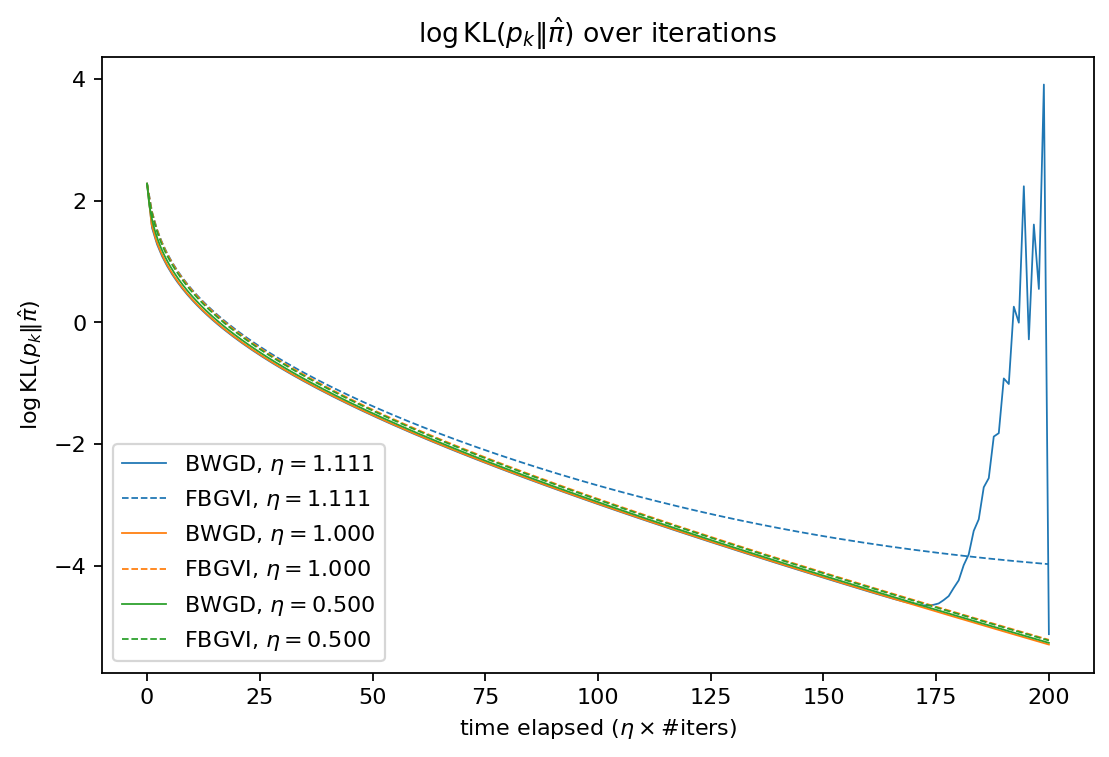

In [32]:
alpha_choice = 5e-3
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = False)
exp.run_experiment(iters_list = [180, 200, 400], time = 200)